Growth rate prediction


In [170]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest, f_regression
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor

In [146]:
df=pd.read_csv('/content/startup_growth_investment_data.csv')
df.head()

,Startup Name,Industry,Funding Rounds,Investment Amount (USD),Valuation (USD),Number of Investors,Country,Year Founded,Growth Rate (%)
0,Startup_1,Blockchain,8,1.335166e+09,6.621448e+09,50,Germany,2012,77.10
1,Startup_2,SaaS,2,2.781498e+09,8.363214e+09,36,UK,2006,105.52
2,Startup_3,EdTech,10,3.309032e+09,1.548270e+10,39,Singapore,2016,190.47
3,Startup_4,Fintech,5,4.050196e+09,1.268253e+10,44,France,2021,9.44
4,Startup_5,EdTech,9,1.645080e+09,6.887966e+09,48,India,2011,192.00


In [147]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Startup Name             5000 non-null   object 
 1   Industry                 5000 non-null   object 
 2   Funding Rounds           5000 non-null   int64  
 3   Investment Amount (USD)  5000 non-null   float64
 4   Valuation (USD)          5000 non-null   float64
 5   Number of Investors      5000 non-null   int64  
 6   Country                  5000 non-null   object 
 7   Year Founded             5000 non-null   int64  
 8   Growth Rate (%)          5000 non-null   float64
dtypes: float64(3), int64(3), object(3)
memory usage: 351.7+ KB


In [148]:
df.isnull().sum()

,0
Startup Name,0
Industry,0
Funding Rounds,0
Investment Amount (USD),0
Valuation (USD),0
Number of Investors,0
Country,0
Year Founded,0
Growth Rate (%),0


In [149]:
df.duplicated()

,0
0,False
1,False
2,False
3,False
4,False
...,...
4995,False
4996,False
4997,False
4998,False


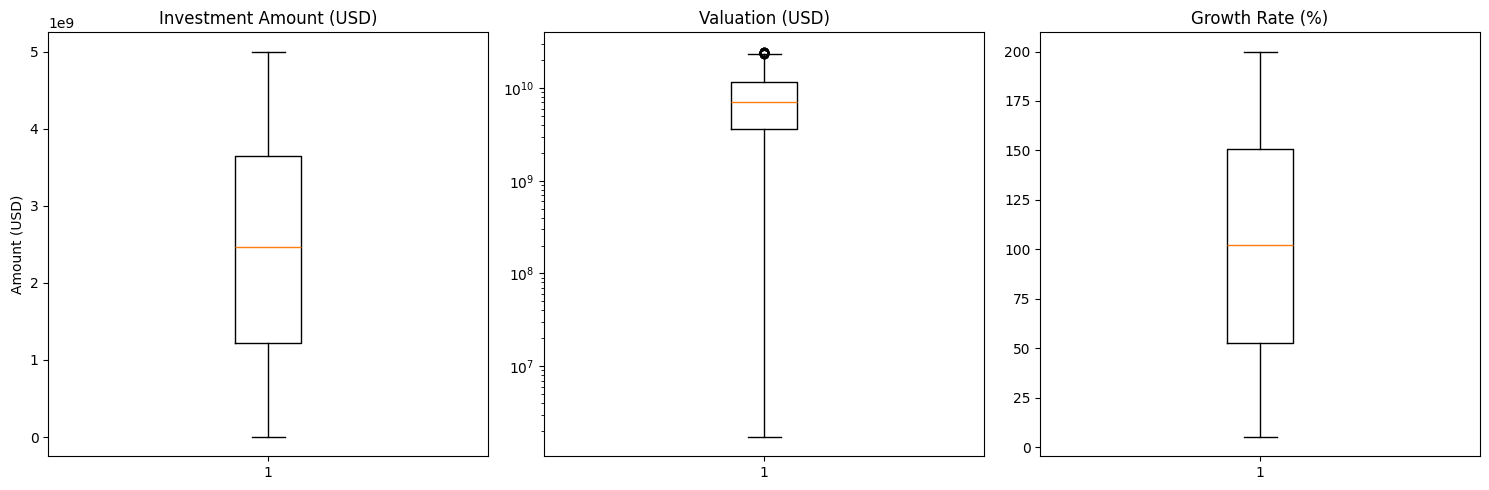

In [150]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Investment Amount
axes[0].boxplot(df['Investment Amount (USD)'])
axes[0].set_title('Investment Amount (USD)')
axes[0].set_ylabel('Amount (USD)')

# Valuation with log scale to handle outliers
axes[1].boxplot(df['Valuation (USD)'])
axes[1].set_title('Valuation (USD)')
axes[1].set_yscale('log')  # Log scale for better visualization

# Growth Rate
axes[2].boxplot(df['Growth Rate (%)'])
axes[2].set_title('Growth Rate (%)')

plt.tight_layout()
plt.show()


In [151]:
# Compute Q1 (25th percentile) and Q3 (75th percentile)
Q1 = df['Valuation (USD)'].quantile(0.25)
Q3 = df['Valuation (USD)'].quantile(0.75)
IQR = Q3 - Q1  # Interquartile Range

# Define upper and lower bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Detect outliers
outliers = df[(df['Valuation (USD)'] < lower_bound) | (df['Valuation (USD)'] > upper_bound)]
print("Number of Outliers:", outliers.shape[0])
print(outliers)

Number of Outliers: 17
      Startup Name    Industry  Funding Rounds  Investment Amount (USD)  \
77      Startup_78  HealthTech               8             4.940530e+09   
435    Startup_436     Biotech              10             4.991897e+09   
789    Startup_790  E-commerce               3             4.850129e+09   
1412  Startup_1413     Fintech               4             4.918505e+09   
1790  Startup_1791          AI               2             4.933705e+09   
1806  Startup_1807     Fintech               7             4.976302e+09   
1978  Startup_1979     Biotech               7             4.898555e+09   
2374  Startup_2375          AI               3             4.914634e+09   
2437  Startup_2438      EdTech               6             4.855344e+09   
2520  Startup_2521  HealthTech               1             4.908986e+09   
2552  Startup_2553  Blockchain               6             4.975483e+09   
3271  Startup_3272  E-commerce              10             4.910883e+09   
34

In [152]:
# Copy original data for comparison
df_original = df[['Valuation (USD)']].copy()

# Apply Robust Scaling
scaler = RobustScaler()
df['Valuation (USD)'] = scaler.fit_transform(df[['Valuation (USD)']])

# Compare before & after
print("Before Scaling:\n", df_original.describe())
print("\nAfter Scaling:\n", df.describe())


Before Scaling:
        Valuation (USD)
count     5.000000e+03
mean      7.971059e+09
std       5.479487e+09
min       1.722547e+06
25%       3.598305e+09
50%       7.002304e+09
75%       1.147676e+10
max       2.470906e+10

After Scaling:
        Funding Rounds  Investment Amount (USD)  Valuation (USD)  \
count     5000.000000             5.000000e+03     5.000000e+03   
mean         5.491600             2.455567e+09     1.229626e-01   
std          2.913353             1.423787e+09     6.955030e-01   
min          1.000000             1.102610e+06    -8.885733e-01   
25%          3.000000             1.221506e+09    -4.320645e-01   
50%          6.000000             2.460634e+09     6.052559e-17   
75%          8.000000             3.639951e+09     5.679355e-01   
max         10.000000             4.999544e+09     2.247492e+00   

       Number of Investors  Year Founded  Growth Rate (%)  
count          5000.000000   5000.000000      5000.000000  
mean             25.542000   2011.5

In [153]:
df.describe()

,Funding Rounds,Investment Amount (USD),Valuation (USD),Number of Investors,Year Founded,Growth Rate (%)
count,5000.000000,5.000000e+03,5.000000e+03,5000.000000,5000.000000,5000.000000
mean,5.491600,2.455567e+09,1.229626e-01,25.542000,2011.544000,102.091732
std,2.913353,1.423787e+09,6.955030e-01,14.271838,6.885285,56.179781
min,1.000000,1.102610e+06,-8.885733e-01,1.000000,2000.000000,5.060000
25%,3.000000,1.221506e+09,-4.320645e-01,13.000000,2006.000000,52.815000
50%,6.000000,2.460634e+09,6.052559e-17,25.000000,2012.000000,102.215000
75%,8.000000,3.639951e+09,5.679355e-01,38.000000,2018.000000,150.580000
max,10.000000,4.999544e+09,2.247492e+00,50.000000,2023.000000,199.970000


In [154]:
df.head()

,Startup Name,Industry,Funding Rounds,Investment Amount (USD),Valuation (USD),Number of Investors,Country,Year Founded,Growth Rate (%)
0,Startup_1,Blockchain,8,1.335166e+09,-0.048342,50,Germany,2012,77.10
1,Startup_2,SaaS,2,2.781498e+09,0.172738,36,UK,2006,105.52
2,Startup_3,EdTech,10,3.309032e+09,1.076403,39,Singapore,2016,190.47
3,Startup_4,Fintech,5,4.050196e+09,0.720982,44,France,2021,9.44
4,Startup_5,EdTech,9,1.645080e+09,-0.014513,48,India,2011,192.00


*Predicting Growth Rate*

In [155]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Startup Name             5000 non-null   object 
 1   Industry                 5000 non-null   object 
 2   Funding Rounds           5000 non-null   int64  
 3   Investment Amount (USD)  5000 non-null   float64
 4   Valuation (USD)          5000 non-null   float64
 5   Number of Investors      5000 non-null   int64  
 6   Country                  5000 non-null   object 
 7   Year Founded             5000 non-null   int64  
 8   Growth Rate (%)          5000 non-null   float64
dtypes: float64(3), int64(3), object(3)
memory usage: 351.7+ KB


In [156]:
df.select_dtypes(include=['object', 'category']).columns    #Categorical data

Index(['Startup Name', 'Industry', 'Country'], dtype='object')

*Applying one hot encoding for it*

In [157]:
# Initialize the Label Encoder
label_encoder = LabelEncoder()

# Apply Label Encoding to categorical columns
df['Industry'] = label_encoder.fit_transform(df['Industry'])
df['Country'] = label_encoder.fit_transform(df['Country'])

# Display first few rows
df.head()


,Startup Name,Industry,Funding Rounds,Investment Amount (USD),Valuation (USD),Number of Investors,Country,Year Founded,Growth Rate (%)
0,Startup_1,2,8,1.335166e+09,-0.048342,50,5,2012,77.10
1,Startup_2,7,2,2.781498e+09,0.172738,36,8,2006,105.52
2,Startup_3,4,10,3.309032e+09,1.076403,39,7,2016,190.47
3,Startup_4,5,5,4.050196e+09,0.720982,44,4,2021,9.44
4,Startup_5,4,9,1.645080e+09,-0.014513,48,6,2011,192.00


In [158]:
print(df.dtypes)

Startup Name                object
Industry                     int64
Funding Rounds               int64
Investment Amount (USD)    float64
Valuation (USD)            float64
Number of Investors          int64
Country                      int64
Year Founded                 int64
Growth Rate (%)            float64
dtype: object


In [159]:
x=df.drop('Valuation (USD)',axis=1)
y=df['Valuation (USD)']

In [160]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [161]:
x_train = x_train.drop(columns=["Startup Name"], errors="ignore")
x_test = x_test.drop(columns=["Startup Name"], errors="ignore")

In [162]:
#Create and train model
model = LinearRegression()
model.fit(x_train, y_train)

# Predictions
y_pred = model.predict(x_test)

# Model evaluation
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print results
print(f"Intercept: {model.intercept_}")
print(f"Coefficient: {model.coef_[0]}")
print(f"Mean Squared Error: {mse}")
print(f"R² Score: {r2}")

Intercept: -0.8341147561428164
Coefficient: -0.0038171716879672347
Mean Squared Error: 0.13610804737881796
R² Score: 0.7080030892669353


In [166]:
selector = SelectKBest(score_func=f_regression, k=7)  # Select top 7 features
x_train_selected = selector.fit_transform(x_train, y_train)
x_test_selected = selector.transform(x_test)


# Train model again with selected features
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(x_train_selected, y_train)

y_pred = model.predict(x_test_selected)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print results
print(f"Mean Squared Error: {mse}")
print(f"R² Score: {r2}")

Mean Squared Error: 0.14074731649040184
R² Score: 0.6980503181065973


In [169]:
# Train XGBoost Model
model = XGBRegressor(
    n_estimators=300,    # More trees for better accuracy
    learning_rate=0.03,  # Lower learning rate for stability
    max_depth=6,         # Moderate tree depth to prevent overfitting
    subsample=0.8,       # Helps with generalization
    colsample_bytree=0.8,
    random_state=42
)

model.fit(x_train, y_train)

# Predictions
y_pred = model.predict(x_test)

# Model Evaluation
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print Results
print(f"Mean Squared Error (MSE): {mse}")
print(f"R² Score: {r2}")


Mean Squared Error (MSE): 0.14079643044646548
R² Score: 0.697944952378996


*Tune Hyperparameters for Better Performance*

In [171]:
# Define hyperparameter grid
param_grid = {
    "n_estimators": [100, 300, 500],
    "max_depth": [4, 6, 8],
    "learning_rate": [0.01, 0.03, 0.1],
}

# Grid Search
grid_search = GridSearchCV(XGBRegressor(random_state=42), param_grid, scoring="r2", cv=3)
grid_search.fit(x_train, y_train)

# Best Parameters
print("Best Parameters:", grid_search.best_params_)

# Train Model with Best Parameters
best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(x_test)

# Evaluate Best Model
mse_best = mean_squared_error(y_test, y_pred_best)
r2_best = r2_score(y_test, y_pred_best)

print(f"Optimized MSE: {mse_best}")
print(f"Optimized R² Score: {r2_best}")


Best Parameters: {'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 300}
Optimized MSE: 0.13549573997924402
Optimized R² Score: 0.709316691750681
